In [1]:
import pickle 

import matplotlib.pyplot as plt
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from IPython.display import VimeoVideo
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
    roc_auc_score, 
    average_precision_score
)
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline



In [2]:
# Create database
df = pd.read_csv("/home/88ea0b98-3d0c-4465-b720-bcfb4ebf2254/Projects/BankruptcyPoland/Bankruptcy_Poland.csv")

In [3]:
df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A57,A58,A59,A60,A61,A62,A63,A64,class,year
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,0.0,1.0
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,0.0,1.0
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,0.0,1.0
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,0.0,1.0
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,0.0,1.0


In [4]:
# Check Nan values cor each feature
nans_by_col = df.isna().sum()
print("nans_by_col shape:", nans_by_col.shape)
nans_by_col.head()


nans_by_col shape: (66,)


A1     4
A2     5
A3     5
A4    69
A5    54
dtype: int64

In [5]:
# rename the columns that indicate bankruptcy
df = df.rename(columns = {"class":"bankrupt"})

In [6]:
df["bankrupt"].isna().sum()

1

We notice that the column "bankrupt" has only one row when the value is missing and this will be our target. So we drop this single row.


In [7]:
df = df.dropna(subset=["bankrupt"])

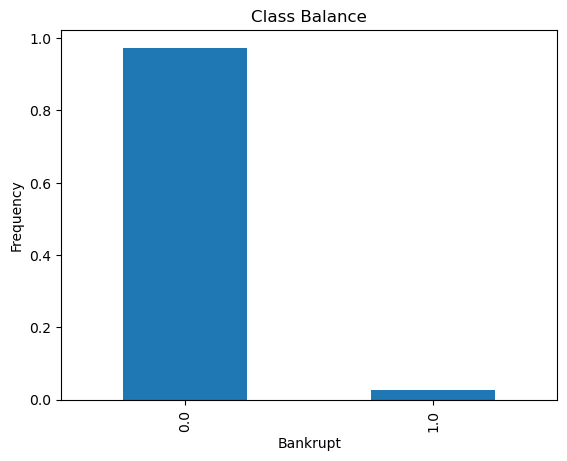

In [8]:
# Plot class balance
fig, ax = plt.subplots()
df["bankrupt"].value_counts(normalize=True).plot(
    kind="bar", xlabel="Bankrupt",ylabel="Frequency",title="Class Balance"
);


In [9]:
null_percent = df.isnull().sum() / len(df)
null_percent.sort_values(ascending = False).head(10)

A37    0.432735
A21    0.208307
A27    0.057891
A60    0.044870
A45    0.044713
A24    0.022592
A41    0.017689
A53    0.016748
A28    0.016748
A64    0.016748
dtype: float64

In the following lines of code, we select the columns where the missing values are more than 4%. In these columns we will fill the missing values with the median of that feature, but we will also add another column to indicate that the value was missing. For the remaining columns, the missing values will be filled with the mean.

In [10]:
null_columns = null_percent[null_percent > 0.04].index

In [11]:
target = "bankrupt"
X = df.drop(columns=target)
y = df[target]
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (25496, 65)
y shape: (25496,)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (20396, 65)
y_train shape: (20396,)
X_test shape: (5100, 65)
y_test shape: (5100,)


In [13]:
for col in null_columns:
    new_col = f"{col}_missing"
    X_train[new_col] = X_train[col].isna().astype(int)
    X_test[new_col] = X_test[col].isna().astype(int)
    median = X_train[col].median()
    X_train[col] = X_train[col].fillna(median)
    X_test[col] = X_test[col].fillna(median)
    

In [14]:
null_columns2 = X_train.columns[X_train.isna().any()]
mean = X_train[null_columns2].mean()
X_train[null_columns2] = X_train[null_columns2].fillna(mean)
X_test[null_columns2] = X_test[null_columns2].fillna(mean)

We use a RandomOverSampler since our data are unbalanced.

In [15]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train,y_train)
print("X_train_over shape:", X_train_over.shape)
X_train_over.head()

X_train_over shape: (39678, 70)


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A61,A62,A63,A64,year,A21_missing,A27_missing,A37_missing,A45_missing,A60_missing
0,0.014984,0.67555,0.070289,1.12370,3.0872,0.000000,0.014984,0.48027,4.08940,0.32445,...,9.6537,50.702,7.1989,11.30800,2.0,1,1,0,0,0
1,-0.140650,0.19364,0.177020,2.26850,11.0330,0.040957,-0.140650,3.71020,0.89954,0.71845,...,5.0098,76.325,4.7822,0.97649,2.0,0,0,0,0,0
2,0.015310,0.77401,0.185680,1.24180,-23.0000,-0.002859,0.011970,0.29197,4.15830,0.22599,...,9.0733,67.401,5.4154,89.50600,3.0,0,0,1,0,0
3,0.043511,0.52112,-0.243330,0.53306,-97.8360,-0.224240,0.070278,0.91168,1.05900,0.47510,...,12.0370,128.490,2.8407,2.04970,3.0,0,0,1,0,0
4,0.135370,0.45185,0.311620,2.04690,10.2340,0.167680,0.167630,1.21310,2.25540,0.54815,...,8.8342,48.172,7.5770,5.77250,1.0,1,0,0,0,0


For this classification problem we use a Random Forest model. The following lines will define the model and we will also do a GridSearch to tune the model and understand what are the best parameters. At the end we will evaluate also the performance of the model.


In [16]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_over,y_train_over)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [17]:
cv_scores = cross_val_score(
    clf,
    X_train_over,
    y_train_over,
    cv=5,
    n_jobs=-1
)


In [18]:
print(cv_scores)



[0.99873992 0.9983619  0.99924395 0.99873976 0.99823566]


In [19]:
df["bankrupt"][df["bankrupt"]==1].sum() / len(df)

0.02631785378098525

In [20]:
params = {
    "max_depth": range(30, 50, 10),
    "n_estimators": range(25, 51, 25),
}

In [21]:
model = GridSearchCV(
    clf,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)


In [ ]:
model.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [ ]:
cv_results = pd.DataFrame(model.cv_results_)
cv_results.head(5)


In [ ]:
best_params = model.best_params_
print(best_params)

In [ ]:
acc_train = model.score(X_train,y_train)
acc_test = model.score(X_test,y_test)

print("Model Training Accuracy:", round(acc_train, 4))
print("Model Test Accuracy:", round(acc_test, 4))

In [ ]:
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_estimator(model,X_test,y_test,ax=ax);

In [ ]:
class_report = class_report=classification_report(y_test,model.predict(X_test)) 
print(class_report)

y_proba = model.predict_proba(X_test)[:,1]


print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("PR-AUC:", average_precision_score(y_test, y_proba))


In [ ]:
# write your code here
fig, ax = plt.subplots()
# Get feature names from training data
features = X_train_over.columns
# Extract importances from model
importances = model.best_estimator_.feature_importances_
# Create a series with feature names and importances
feat_imp = pd.Series(importances,index=features).sort_values()
# Plot 10 most important features
feat_imp.tail(10).plot(kind="barh")

plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");


The Random Forest model achieved high discrimination on the Bankruptcy Poland dataset, with ROC-AUC 0.95 and PR-AUC 0.62, reflecting solid overall performance despite the strong class imbalance. Accuracy is 0.99, but the recall for the minority class is 0.41, indicating many bankrupt cases are still missed. Precision remains high at 0.90 for detected bankruptcies. Feature importance highlights "year" as a key predictor and the artificially added "A27_missing" indicator, which also contributes noticeably. Overall, the model captures general patterns well, though minority class detection could be further improved.